In [41]:
%reset
%pylab inline
import dicom
import pylab
from matplotlib import pyplot as plt
import numpy as np
from skimage import feature, data, exposure
import scipy
from os import walk, path, getcwd, mkdir, makedirs
from Utilities import DCM, Maths, TextureFunctions # Import utilities.
import h5py
from sklearn import svm, metrics
from sklearn.neural_network import MLPClassifier
from matplotlib.colors import Normalize
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Populating the interactive namespace from numpy and matplotlib


# Load HDF5 file

In [42]:
#with h5py.File('NGL_32128_PATCH_5.h5','r') as hf:
with h5py.File('NGL_32_PATCH_36.h5','r') as hf:
    print hf.keys()
    gp1 = hf.get('patient_1a')
    gp3 = hf.get('patient_3')
    gp2 = hf.get('patient_2a')
    
    # LOAD THE DATA FOR ALL VOXELS.
    patient1_data_temp = gp1.get('data')
    patient1_data = np.array(patient1_data_temp)
    
    patient2_data_temp = gp2.get('data')
    patient2_data = np.array(patient2_data_temp)
    
    patient3_data_temp = gp3.get('data')
    patient3_data = np.array(patient3_data_temp)
    
    # LOAD THE MASK AND THE SLICES, IF YOU WANT.
    mask_tmp = gp1.get('mask')
    mask1 = np.array(mask_tmp)
    
    mask_tmp = gp2.get('mask')
    mask2 = np.array(mask_tmp)
    
    mask_tmp = gp3.get('mask')
    mask3 = np.array(mask_tmp)    
    
    #sl_tmp = gp1.get('slices')
    #sl1 = np.array(sl_tmp)
    sl_tmp = gp2.get('slices')
    sl2 = np.array(sl_tmp)
    sl_tmp = gp3.get('slices')
    sl3 = np.array(sl_tmp)    

# ALTERNATIVE WAY TO SCALE THE DATA.
scaler = StandardScaler()
patient1_data[:,:-1] = scaler.fit_transform(patient1_data[:,:-1])
patient2_data[:,:-1] = scaler.fit_transform(patient2_data[:,:-1])
patient3_data[:,:-1] = scaler.fit_transform(patient3_data[:,:-1])


all_data_training = np.concatenate((patient1_data,patient2_data))
all_data_testing_validation = patient3_data
print "Done."
print all_data_training.shape
print all_data_testing_validation.shape

[u'patient_1a', u'patient_2a', u'patient_3']
Done.
(5741145, 19)
(2682278, 19)


In [46]:
indexes_H_train = all_data_training[:,-1] == 1
indexes_F_train = all_data_training[:,-1] == 2


indexes_H_TV = all_data_testing_validation[:,-1] == 1
indexes_F_TV = all_data_testing_validation[:,-1] == 2

XY_train_H = all_data_training[indexes_H_train,:]
XY_train_F = all_data_training[indexes_F_train,:]

print XY_train_F.shape

XY_TV_H = all_data_testing_validation[indexes_H_TV,:]
XY_TV_F = all_data_testing_validation[indexes_F_TV,:]

np.random.seed(412)
np.random.shuffle(XY_train_H)
np.random.shuffle(XY_train_F)
np.random.shuffle(XY_TV_H)
np.random.shuffle(XY_TV_F)

Ntrain = 100000 # Will be twice this number!
Nvalid = 200000
Ntest = 200000

XY_TRAIN = np.concatenate([XY_train_H[0:Ntrain,:],XY_train_F[0:Ntrain,:]])
XY_TEST = np.concatenate([XY_TV_H[0:Ntest,:],XY_TV_F[0:Ntest,:]])
XY_VALID = np.concatenate([XY_TV_H[Ntest:Ntest+Nvalid,:],XY_TV_F[Ntest:Ntest+Nvalid,:]])

print XY_TRAIN.shape
print XY_TEST.shape
print XY_VALID.shape

(406969, 19)
(200000, 19)
(400000, 19)
(289620, 19)


In [45]:
print np.unique(XY_TV_H[:,-1])

[ 1.]


In [25]:
# Uses the scikit-learn Multi Layer Perceptron package
#x = training_set_X
#y = training_set_Y

x = XY_TRAIN[:,:-1]
y = XY_TRAIN[:,-1]-1

xt = XY_TEST[:,:-1]
yt = XY_TEST[:,-1]-1

clf = MLPClassifier(solver='sgd', alpha=1e-3, hidden_layer_sizes=(100,9), random_state=1, max_iter= 100, 
                    activation='relu', early_stopping = False, learning_rate = "adaptive",beta_1= 0.8,beta_2 = 0.999)

#clf = MLPClassifier(solver='adam', alpha=1e-3, hidden_layer_sizes=(200,9), random_state=1, max_iter= 5000000, 
#                    activation='relu', early_stopping = False, learning_rate = "adaptive",beta_1= 0.8,beta_2 = 0.999)

clf.fit(x, y) 

ConfusionMatrix = metrics.confusion_matrix(yt, clf.predict(xt), labels=None, sample_weight=None)
print ConfusionMatrix
print("Sensitivity:")
print((ConfusionMatrix[1,1].astype(float))/(ConfusionMatrix[1,1].astype(float)+ConfusionMatrix[1,0].astype(float)))
print("Specificity:")
print((ConfusionMatrix[0,0].astype(float))/(ConfusionMatrix[0,0].astype(float)+ConfusionMatrix[0,1].astype(float)))

[[224718  75282]
 [262175  37825]]
Sensitivity:
0.126083333333
Specificity:
0.74906


In [29]:
# TRAIN THE PARAMETERS.

#C_range = np.logspace(-2, 10, 13)
#gamma_range = np.logspace(-9, 3, 13)
#param_grid = dict(gamma=gamma_range, C=C_range)
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
#grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=cv)
#grid.fit(TRAINING_X_SUBSET, TRAINING_Y_SUBSET)

#print("The best parameters are %s with a score of %0.2f"
#      % (grid.best_params_, grid.best_score_))



In [4]:
C_range = np.logspace(-2, 7, 10)
gamma_range = np.logspace(-9, 3, 13)

classifiers = []
Perf_Te =[]
Perf_V = [] # accuracy.
CM_Te = []
CM_V = []
Spec_V = []
Sens_V = []
Spec_Te = []
Sens_Te = []

for C in C_range:
    print C
    for gamma in gamma_range:
        print gamma
        clf = svm.SVC(C=C, gamma=gamma, class_weight='balanced',cache_size=1000)
        clf.fit(TRAINING_X_SUBSET, TRAINING_Y_SUBSET)
        classifiers.append((C, gamma, clf))
        
        predicted_classes_test = clf.predict(TESTING_X_SUBSET)
        predicted_classes_V = clf.predict(VALID_X_SUBSET)
        
        ConfMatTe = metrics.confusion_matrix(TESTING_Y_SUBSET, predicted_classes_test, labels=None)
        Perf_Te.append(np.sum(np.diag(ConfMatTe).astype(float))/np.sum(ConfMatTe).astype(float))
        CM_Te.append(ConfMatTe)
        Spec_Te.append(ConfMatTe[1,1].astype(float) / ( ConfMatTe[1,1].astype(float) + ConfMatTe[1,0].astype(float)))
        Sens_Te.append(ConfMatTe[0,0].astype(float) / ( ConfMatTe[0,0].astype(float) + ConfMatTe[0,1].astype(float)))    
        
        ConfMatV = metrics.confusion_matrix(VALID_Y_SUBSET, predicted_classes_V, labels=None)
        Perf_V.append(np.sum(np.diag(ConfMatV).astype(float))/np.sum(ConfMatV).astype(float))
        CM_V.append(ConfMatV)
        Spec_V.append(ConfMatV[1,1].astype(float) / ( ConfMatV[1,1].astype(float) + ConfMatV[1,0].astype(float)))
        Sens_V.append(ConfMatV[0,0].astype(float) / ( ConfMatV[0,0].astype(float) + ConfMatV[0,1].astype(float)))        

Acc_Te = np.array(Perf_Te).reshape(len(C_range),len(gamma_range))
AccV = np.array(Perf_V).reshape(len(C_range),len(gamma_range))

SpecV = np.array(Spec_V).reshape(len(C_range),len(gamma_range))
SensV =  np.array(Sens_V).reshape(len(C_range),len(gamma_range))
SpecTe = np.array(Spec_Te).reshape(len(C_range),len(gamma_range))
SensTe =  np.array(Sens_Te).reshape(len(C_range),len(gamma_range))

plt.figure
plt.imshow(Acc_Te, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(AccV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SpecTe, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SensTe, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SpecV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SensV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

print CM_V[0].shape

0.01
1e-09
1e-08
1e-07
1e-06
1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0


KeyboardInterrupt: 

Choisis les paramères optimaux ici.


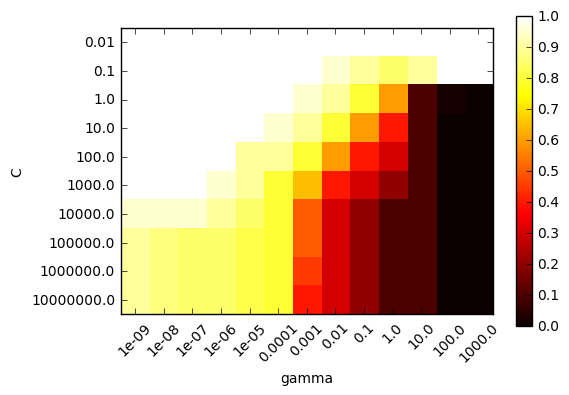

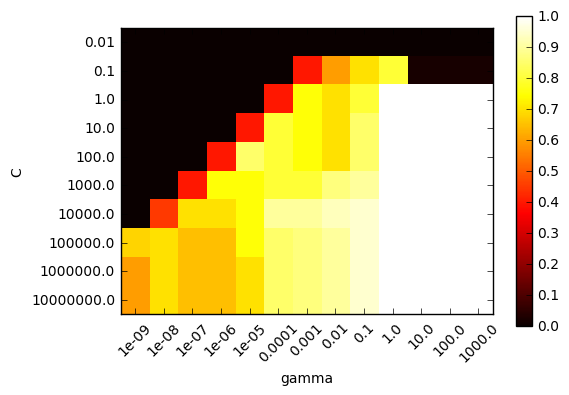

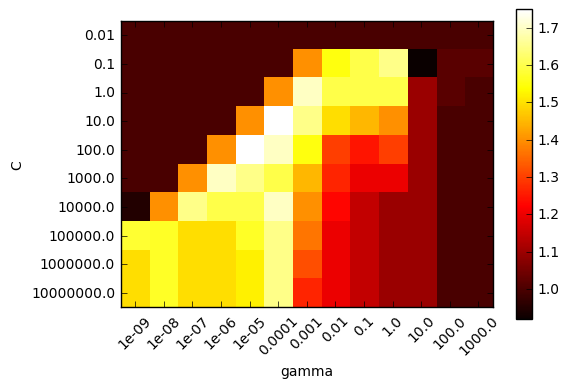

In [73]:
print "Choisis les paramères optimaux ici."
C_range = np.logspace(-2, 7, 10)
gamma_range = np.logspace(-9, 3, 13)

SpecV = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,
        1,1,1,1,1,1,1,.95,.9,.85,.9,1,1,
        1,1,1,1,1,1,.95,.9,.8,.6,.1,.02,0,
        1,1,1,1,1,.95,.9,.8,.6,.4,.1,0,0,
        1,1,1,1,.9,.9,.8,.6,.4,.3,.1,0,0,
        1,1,1,.95,.9,.8,.65,.4,.3,.2,.1,0,0,
        .95,.95,.95,.9,.85,.8,.5,.3,.2,.1,.1,0,0,
        .9,.87,.85,.85,.82,.8,.5,.3,.2,.1,.1,0,0,
        .9,.87,.85,.85,.82,.8,.45,.3,.2,.1,.1,0,0,
        .9,.87,.85,.85,.82,.8,.4,.3,.2,.1,.1,0,0,])

SensV = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,
        0,0,0,0,0,0,.4,.6,.7,.8,.02,0.02,0.02,
        0,0,0,0,0,.4,.75,.7,.8,1,1,1,1,
        0,0,0,0,0.4,.8,.75,.7,.85,1,1,1,1,
        0,0,0,0.4,.85,.8,.75,.7,0.85,1,1,1,1,
        0,0,0.4,.75,.75,.8,.8,.87,.9,1,1,1,1,
        0,.45,.7,.7,.75,.9,.9,.93,.95,1,1,1,1,
        .68,.7,.65,.65,.75,.85,.87,.9,.95,1,1,1,1,
        .6,.7,.65,.65,.7,.85,.87,.9,.95,1,1,1,1,
        .6,.7,.65,.65,.7,.85,.87,.9,.95,1,1,1,1])


SpecV = np.array(SpecV).reshape(len(C_range),len(gamma_range))
SensV = np.array(SensV).reshape(len(C_range),len(gamma_range))

#Spec2 = 
plt.figure
plt.imshow(SpecV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SensV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SensV+SpecV, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

Et ici ça te dit ta performance de généralisation à peu près.


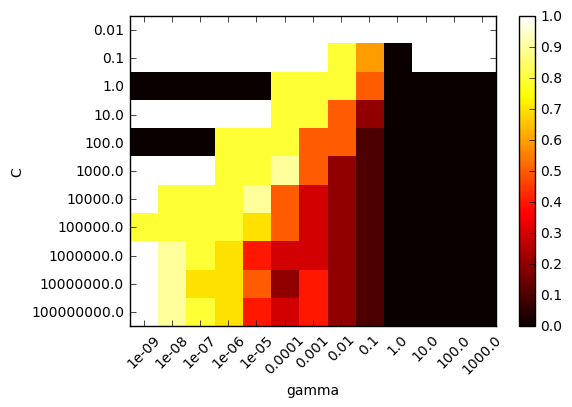

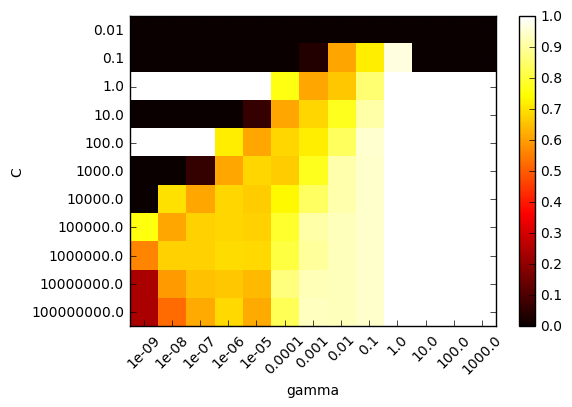

In [27]:
print "Et ici ça te dit ta performance de généralisation à peu près."
plt.figure
plt.imshow(SpecTe, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

plt.figure
plt.imshow(SensTe, interpolation='nearest', cmap=plt.cm.hot)
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

In [48]:
# Train a SVM.

x = XY_TRAIN[:,:-1]
y = XY_TRAIN[:,-1]-1

xt = XY_TEST[:,:-1]
yt = XY_TEST[:,-1]-1

xv = XY_VALID[:,:-1]
yv = XY_VALID[:,-1]-1


clf = svm.SVC(C=1,cache_size=1000,class_weight='balanced',gamma='auto', kernel='rbf')
clf = svm.SVC(C=1700,cache_size=1000,class_weight='balanced',gamma=0.0075, kernel='rbf',tol=1e-5)
#clf = svm.SVC(C=1500,cache_size=1000,class_weight='balanced',gamma=0.0075,kernel='poly',degree = 3, coef0 = 1)
#clf = svm.SVC(C=1,cache_size=1000,class_weight='balanced',gamma=0.5,kernel='sigmoid',coef0=0.0)
clf.fit(x, y) 

predicted_classes = clf.predict(x)

#print "Total error (%) on the dataset."
#print 100*(1 - np.mean(TRAINING_Y_SUBSET==predicted_classes))

# ---------------------------------------------------
### SPÉCIFICITÉ ET SENSITIVITÉ - TRAINING SET
# ---------------------------------------------------
print "============================================"
ConfMat = metrics.confusion_matrix(y, predicted_classes, labels=None)
TP = ConfMat[0,0] # True positives (healthy tissue taken as healthy.)
FN = ConfMat[0,1] # False Negatives (healthy tissue taken as fibrosis.)
FP = ConfMat[1,0] # False Positives (fibrosis tissue taken as healthy.)
TN = ConfMat[1,1] # True Negatives (fibrosis taken as fibrosis)
print "Confusion matrix:"
print ConfMat
print "Sensitivity, error on the fibrosis :" # True positive rate.
print TN.astype(float)/(TN+FP).astype(float)
print "Specificity, healthy lung rate:" # True negative rate.
print TP.astype(float)/(TP+FN).astype(float)


# ---------------------------------------------------
### SPÉCIFICITÉ ET SENSITIVITÉ - TEST SET
# ---------------------------------------------------
print "============================================"
predicted_classes_test = clf.predict(xt)
ConfMat = metrics.confusion_matrix(yt, predicted_classes_test, labels=None)
TP = ConfMat[0,0] # True positives (healthy tissue taken as healthy.)
FN = ConfMat[0,1] # False Negatives (healthy tissue taken as fibrosis.)
FP = ConfMat[1,0] # False Positives (fibrosis tissue taken as healthy.)
TN = ConfMat[1,1] # True Negatives (fibrosis taken as fibrosis)
print "Confusion matrix:"
print ConfMat
print "Specificity, healthy lung rate:" # True negative rate.
print TN.astype(float)/(TN+FP).astype(float)
print "Sensitivity, error on the fibrosis :" # True positive rate.
print TP.astype(float)/(TP+FN).astype(float)

# ---------------------------------------------------
### SPÉCIFICITÉ ET SENSITIVITÉ - VALID SET
# ---------------------------------------------------
print "============================================"
predicted_classes_v = clf.predict(xv)
ConfMatV = metrics.confusion_matrix(yv, predicted_classes_v, labels=None)
TP = ConfMatV[0,0] # True positives (healthy tissue taken as healthy.)
FN = ConfMatV[0,1] # False Negatives (healthy tissue taken as fibrosis.)
FP = ConfMatV[1,0] # False Positives (fibrosis tissue taken as healthy.)
TN = ConfMatV[1,1] # True Negatives (fibrosis taken as fibrosis)
print "Confusion matrix:"
print ConfMatV
print "Sensitivity, error on the fibrosis:" # True negative rate.
print TN.astype(float)/(TN+FP).astype(float)
print "Specificity, healthy lung rate:" # True negative rate.
print TP.astype(float)/(TP+FN).astype(float)

# Confusion matrix
# [actual class is 0, predicted class is 0          actual class is 0, predicted class is 1]
# [actual class is 1, predicted class is 0          actual class is 1, predicted class is 1]


# ---------------------------------------------------
### SPÉCIFICITÉ ET SENSITIVITÉ - SUR TOUTE
# ---------------------------------------------------
print "============================================"
#print " ON ALL"
#print "============================================"
#predicted_classes_A = clf.predict(data_X)
#ConfMatA = metrics.confusion_matrix(data_Y-1, predicted_classes_A, labels=None)
#TP = ConfMatA[0,0] # True positives (healthy tissue taken as healthy.)
#FN = ConfMatA[0,1] # False Negatives (healthy tissue taken as fibrosis.)
#FP = ConfMatA[1,0] # False Positives (fibrosis tissue taken as healthy.)
#TN = ConfMatA[1,1] # True Negatives (fibrosis taken as fibrosis)
#print "Confusion matrix on all:"
#print ConfMatA
#print "Specificity, healthy lung rate:" # True negative rate.
#print TN.astype(float)/(TN+FP).astype(float)
#print "Sensitivity, error on the fibrosis :" # True positive rate.
#print TP.astype(float)/(TP+FN).astype(float)

Confusion matrix:
[[82798 17202]
 [ 3340 96660]]
Sensitivity, error on the fibrosis :
0.9666
Specificity, healthy lung rate:
0.82798
Confusion matrix:
[[146183  53817]
 [151346  48654]]
Specificity, healthy lung rate:
0.24327
Sensitivity, error on the fibrosis :
0.730915
Confusion matrix:
[[146226  53774]
 [ 67766  21854]]
Sensitivity, error on the fibrosis:
0.24385181879
Specificity, healthy lung rate:
0.73113


[[27250 12750]
 [    0     0]]
[ 0.]


# =======================================
#  RECONSTRUCTION OF A SLICE.
# =======================================

/Users/mikael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 2; dimension is 238 but corresponding boolean dimension is 200


Confusion matrix:
[[3084 5654]
 [ 108 2531]]
Specificity, healthy lung rate:
0.959075407351
Sensitivity, error on the fibrosis :
0.352941176471


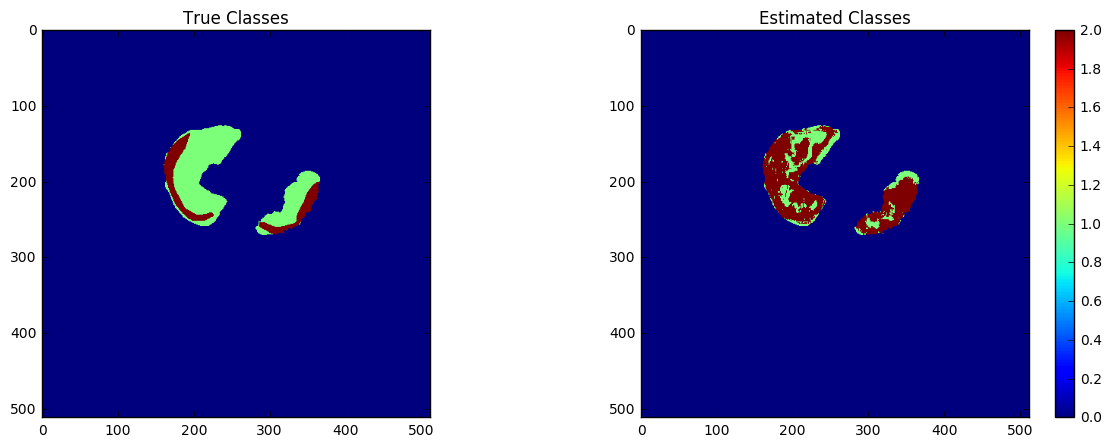

In [36]:
## TEST YOUR ALGORITHM ON A SPECIFIC SLICE.
## ONLY THING YOU NEED : MAKE SURE CLF IS THE NAME OF YOUR ML ALGORITHM.


Nfeatures = patient2_data.shape[1] - 1
truemap_patient = np.zeros(mask2.shape)
truemap_patient[mask2.astype(bool)] = patient2_data[:,-1]
truedat_list = list()
    
for i in range(Nfeatures):
    truedata_patient = np.zeros(mask1.shape)
    truedata_patient[mask2.astype(bool)] = patient2_data[:,i]
    truedat_list.append(truedata_patient)

NICE_SLICE = 102 # 102 is good.

temporary = truedat_list[0][:,:,NICE_SLICE]
wow = temporary[mask2[:,:,NICE_SLICE].astype(bool)] 
potato = np.zeros((len(wow),Nfeatures)) # potato is the array you pass to the prediction algorithm.
# it holds npixels of lung in the slice x nFeature elements.

for i in range(Nfeatures):
    tmp = truedat_list[i][:,:,NICE_SLICE]
    potato[:,i] = tmp[mask2[:,:,NICE_SLICE].astype(bool)] 

YOUR_ESTIMATED_ARRAY = clf.predict(potato) 
#YOUR_ESTIMATED_ARRAY = clf.predict_proba(potato)

estimated_map_reconstructed = np.zeros(mask2[:,:,NICE_SLICE].shape)
estimated_map_reconstructed[mask2[:,:,NICE_SLICE].astype(bool)] = YOUR_ESTIMATED_ARRAY + 1

fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title("True Classes")
ax[0].imshow(truemap_patient[:,:,NICE_SLICE],vmin=0,vmax=2)

ax[1].set_title("Estimated Classes")
im = ax[1].imshow(estimated_map_reconstructed,vmin=0,vmax=2)
fig.colorbar(im)

######################################################################

predicted_classes_potato = clf.predict(potato)
WTF1 = truemap_patient[:,:,NICE_SLICE]
WTF2 = WTF1[mask2[:,:,NICE_SLICE].astype(bool)]
ConfMatPotato = metrics.confusion_matrix(WTF2,predicted_classes_potato+1,labels=None)

TP = ConfMatPotato[0,0] # True positives (healthy tissue taken as healthy.)
FN = ConfMatPotato[0,1] # False Negatives (healthy tissue taken as fibrosis.)
FP = ConfMatPotato[1,0] # False Positives (fibrosis tissue taken as healthy.)
TN = ConfMatPotato[1,1] # True Negatives (fibrosis taken as fibrosis)
print "Confusion matrix:"
print ConfMatPotato
print "Specificity, healthy lung rate:" # True negative rate.
print TN.astype(float)/(TN+FP).astype(float)
print "Sensitivity, error on the fibrosis :" # True positive rate.
print TP.astype(float)/(TP+FN).astype(float)


#TESTING_X_SUBSET = training_set_X[Ntrain:Ntrain+Ntest,:]
#TESTING_Y_SUBSET = training_set_Y[Ntrain:Ntrain+Ntest]

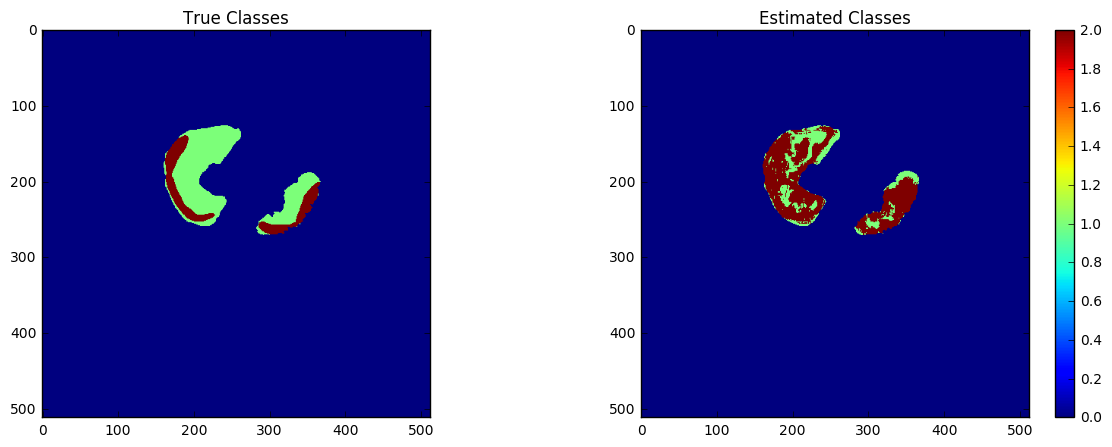

In [38]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title("True Classes")
ax[0].imshow(truemap_patient[:,:,103],vmin=0,vmax=2)

ax[1].set_title("Estimated Classes")
im = ax[1].imshow(estimated_map_reconstructed,vmin=0,vmax=2)
fig.colorbar(im)